In [2]:
# Лабораторна робота 3: Моделювання СМО (Система Масового Обслуговування)
# Модель кол-центру з двома типами відмов: Balking та Reneging

import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np

## 1. Параметри моделі

Визначаємо всі ключові параметри симуляції кол-центру інтернет-магазину.

In [3]:
# ==================== ПАРАМЕТРИ МОДЕЛІ ====================

# Час симуляції (хвилини)
SIM_DURATION = 480  # 8-годинний робочий день

# Кількість операторів (каналів обслуговування)
NUM_OPERATORS = 3

# Середній інтервал між дзвінками (хвилини)
AVG_ARRIVAL_INTERVAL = 2.0

# Час обслуговування (розмови) - хвилини
MIN_SERVICE_TIME = 3.0
MAX_SERVICE_TIME = 8.0

# Максимальна довжина черги
MAX_QUEUE_SIZE = 5

# Максимальний час очікування клієнта (хвилини)
PATIENCE_TIME = 10.0

# Детальний вивід подій (True/False)
VERBOSE = False  # Змініть на True для детального логу

print("Параметри моделі встановлено:")
print(f"  - Тривалість симуляції: {SIM_DURATION} хв")
print(f"  - Оператори: {NUM_OPERATORS}")
print(f"  - Середній інтервал між дзвінками: {AVG_ARRIVAL_INTERVAL} хв")
print(f"  - Час обслуговування: {MIN_SERVICE_TIME}-{MAX_SERVICE_TIME} хв")
print(f"  - Макс. розмір черги: {MAX_QUEUE_SIZE}")
print(f"  - Терпіння клієнта: {PATIENCE_TIME} хв")

Параметри моделі встановлено:
  - Тривалість симуляції: 480 хв
  - Оператори: 3
  - Середній інтервал між дзвінками: 2.0 хв
  - Час обслуговування: 3.0-8.0 хв
  - Макс. розмір черги: 5
  - Терпіння клієнта: 10.0 хв


## 2. Клас для збору статистики

Створюємо клас для відстеження всіх метрик симуляції.

In [4]:
class Statistics:
    """Клас для збору статистики симуляції"""
    def __init__(self):
        self.total_calls = 0        # Загальна кількість дзвінків
        self.balked_calls = 0       # Відмови через переповнену чергу (Balking)
        self.reneged_calls = 0      # Відмови через довге очікування (Reneging)
        self.processed_calls = 0    # Успішно оброблені дзвінки
        self.wait_times = []        # Час очікування для оброблених
        
    def reset(self):
        """Скидає всю статистику"""
        self.__init__()
        
    def print_summary(self):
        """Виводить підсумкову статистику"""
        print("=" * 70)
        print("РЕЗУЛЬТАТИ СИМУЛЯЦІЇ")
        print("=" * 70)
        
        print(f"\nЗАГАЛЬНА СТАТИСТИКА:")
        print(f"  Загальна кількість дзвінків: {self.total_calls}")
        print(f"  Успішно оброблених: {self.processed_calls}")
        print(f"  Втрачених дзвінків: {self.balked_calls + self.reneged_calls}")
        
        print(f"\nВІДМОВИ:")
        balking_percent = (self.balked_calls / self.total_calls * 100) if self.total_calls > 0 else 0
        print(f"  Balking (черга переповнена): {self.balked_calls} ({balking_percent:.1f}%)")
        
        reneging_percent = (self.reneged_calls / self.total_calls * 100) if self.total_calls > 0 else 0
        print(f"  Reneging (вийшли з черги): {self.reneged_calls} ({reneging_percent:.1f}%)")
        
        lost_percent = ((self.balked_calls + self.reneged_calls) / self.total_calls * 100) if self.total_calls > 0 else 0
        print(f"  ЗАГАЛЬНИЙ % втрачених: {lost_percent:.1f}%")
        
        print(f"\nОБСЛУГОВУВАННЯ:")
        success_percent = (self.processed_calls / self.total_calls * 100) if self.total_calls > 0 else 0
        print(f"  Успішно оброблених: {self.processed_calls} ({success_percent:.1f}%)")
        
        if self.wait_times:
            avg_wait = statistics.mean(self.wait_times)
            min_wait = min(self.wait_times)
            max_wait = max(self.wait_times)
            median_wait = statistics.median(self.wait_times)
            
            print(f"\nЧАС ОЧІКУВАННЯ (для оброблених дзвінків):")
            print(f"  Середній: {avg_wait:.2f} хв")
            print(f"  Медіана: {median_wait:.2f} хв")
            print(f"  Мінімальний: {min_wait:.2f} хв")
            print(f"  Максимальний: {max_wait:.2f} хв")
        else:
            print(f"\nЧАС ОЧІКУВАННЯ: Немає даних")
            
        print("=" * 70)

# Створюємо глобальний об'єкт статистики
stats = Statistics()
print("Клас Statistics створено")

Клас Statistics створено


## 3. Процес клієнта (customer_call)

Це основна функція, яка моделює поведінку одного клієнта:

1. **Balking** - клієнт перевіряє довжину черги ПЕРЕД тим як стати в неї. Якщо черга переповнена (>= MAX_QUEUE_SIZE), клієнт не стає в чергу.

2. **Reneging** - якщо клієнт став в чергу, він чекає з обмеженим терпінням (PATIENCE_TIME). Якщо не дочекався оператора, він виходить з черги.

3. **Обслуговування** - якщо клієнт дочекався, він спілкується з оператором протягом випадкового часу (MIN_SERVICE_TIME - MAX_SERVICE_TIME).

In [5]:
def customer_call(env, customer_id, operators):
    """
    Моделює один дзвінок клієнта в кол-центр

    Args:
        env: середовище SimPy
        customer_id: унікальний ідентифікатор клієнта
        operators: ресурс SimPy (оператори)
    """
    arrival_time = env.now
    if VERBOSE:
        print(f"[{env.now:.1f} хв] Клієнт #{customer_id} дзвонить")

    # ===== BALKING: Перевірка черги ПЕРЕД запитом =====
    queue_length = len(operators.queue)
    if queue_length >= MAX_QUEUE_SIZE:
        if VERBOSE:
            print(f"[{env.now:.1f} хв] Клієнт #{customer_id} НЕ стає в чергу (черга переповнена: {queue_length})")
        stats.balked_calls += 1
        return  # Відмова типу Balking

    # ===== Клієнт робить запит на оператора =====
    request = operators.request()
    if VERBOSE:
        print(f"[{env.now:.1f} хв] Клієнт #{customer_id} стає в чергу (довжина: {queue_length})")

    # ===== RENEGING: Очікування з обмеженим терпінням =====
    # Чекаємо на дві події одночасно: отримання ресурсу АБО закінчення терпіння
    results = yield request | env.timeout(PATIENCE_TIME)

    # ===== Перевірка результату: дочекався чи ні? =====
    if request in results:
        # Клієнт ДОЧЕКАВСЯ оператора
        wait_time = env.now - arrival_time
        if VERBOSE:
            print(f"[{env.now:.1f} хв] Клієнт #{customer_id} отримав оператора (очікував {wait_time:.1f} хв)")

        # Фіксуємо час очікування
        stats.wait_times.append(wait_time)

        # ===== Обслуговування (розмова з оператором) =====
        service_time = random.uniform(MIN_SERVICE_TIME, MAX_SERVICE_TIME)
        yield env.timeout(service_time)

        if VERBOSE:
            print(f"[{env.now:.1f} хв] Клієнт #{customer_id} завершив розмову (тривалість: {service_time:.1f} хв)")

        # Звільнення ресурсу
        yield operators.release(request)

        # Фіксуємо успішне обслуговування
        stats.processed_calls += 1

    else:
        # Клієнт НЕ дочекався - терпіння закінчилося (RENEGING)
        wait_time = env.now - arrival_time
        if VERBOSE:
            print(f"[{env.now:.1f} хв] Клієнт #{customer_id} виходить з черги (чекав {wait_time:.1f} хв)")

        # КРИТИЧНО ВАЖЛИВО: Скасувати запит!
        request.cancel()

        # Фіксуємо відмову типу Reneging
        stats.reneged_calls += 1

print("Функція customer_call створена")

Функція customer_call створена


## 4. Генератор дзвінків (setup)

Ця функція генерує нових клієнтів протягом симуляції з експоненційним розподілом інтервалів між дзвінками.

In [6]:
def setup(env, operators):
    """
    Генерує нових клієнтів протягом симуляції

    Args:
        env: середовище SimPy
        operators: ресурс SimPy (оператори)
    """
    customer_id = 1

    while True:
        # Генеруємо інтервал до наступного дзвінка (експоненційний розподіл)
        interval = random.expovariate(1.0 / AVG_ARRIVAL_INTERVAL)
        yield env.timeout(interval)

        # Створюємо новий дзвінок
        stats.total_calls += 1
        env.process(customer_call(env, customer_id, operators))
        customer_id += 1

print("Функція setup створена")

Функція setup створена


## 5. Основна функція симуляції

Функція яка ініціалізує середовище, створює ресурси (операторів) та запускає симуляцію.

In [7]:
def run_simulation(seed=42):
    """
    Запускає симуляцію кол-центру
    
    Args:
        seed: насіння для генератора випадкових чисел (для відтворюваності)
    """
    print("=" * 70)
    print("СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ")
    print("=" * 70)
    print(f"\nПАРАМЕТРИ:")
    print(f"  Час симуляції: {SIM_DURATION} хв")
    print(f"  Кількість операторів: {NUM_OPERATORS}")
    print(f"  Середній інтервал між дзвінками: {AVG_ARRIVAL_INTERVAL} хв")
    print(f"  Час обслуговування: {MIN_SERVICE_TIME}-{MAX_SERVICE_TIME} хв")
    print(f"  Макс. розмір черги: {MAX_QUEUE_SIZE}")
    print(f"  Терпіння клієнта: {PATIENCE_TIME} хв")
    print(f"  Детальний вивід: {'ТАК' if VERBOSE else 'НІ'}")
    print("\n" + "=" * 70 + "\n")

    # Скидаємо статистику перед новою симуляцією
    stats.reset()
    
    # Ініціалізація середовища та ресурсів
    random.seed(seed)
    env = simpy.Environment()
    operators = simpy.Resource(env, capacity=NUM_OPERATORS)

    # Запуск генератора дзвінків
    env.process(setup(env, operators))

    # Запуск симуляції
    if not VERBOSE:
        print("Симуляція запущена...", end="", flush=True)
    env.run(until=SIM_DURATION)
    if not VERBOSE:
        print(" завершено!")
        
    # Виводимо результати
    stats.print_summary()
    
    return stats

print("Функція run_simulation створена")

Функція run_simulation створена


## 6. Запуск симуляції

Запускаємо симуляцію та отримуємо результати.

In [8]:
# Запускаємо симуляцію
results = run_simulation(seed=42)

СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ

ПАРАМЕТРИ:
  Час симуляції: 480 хв
  Кількість операторів: 3
  Середній інтервал між дзвінками: 2.0 хв
  Час обслуговування: 3.0-8.0 хв
  Макс. розмір черги: 5
  Терпіння клієнта: 10.0 хв
  Детальний вивід: НІ


Симуляція запущена... завершено!
РЕЗУЛЬТАТИ СИМУЛЯЦІЇ

ЗАГАЛЬНА СТАТИСТИКА:
  Загальна кількість дзвінків: 209
  Успішно оброблених: 198
  Втрачених дзвінків: 7

ВІДМОВИ:
  Balking (черга переповнена): 6 (2.9%)
  Reneging (вийшли з черги): 1 (0.5%)
  ЗАГАЛЬНИЙ % втрачених: 3.3%

ОБСЛУГОВУВАННЯ:
  Успішно оброблених: 198 (94.7%)

ЧАС ОЧІКУВАННЯ (для оброблених дзвінків):
  Середній: 1.90 хв
  Медіана: 1.20 хв
  Мінімальний: 0.00 хв
  Максимальний: 9.02 хв


## 7. Візуалізація результатів

Створюємо графіки для кращого розуміння результатів симуляції.

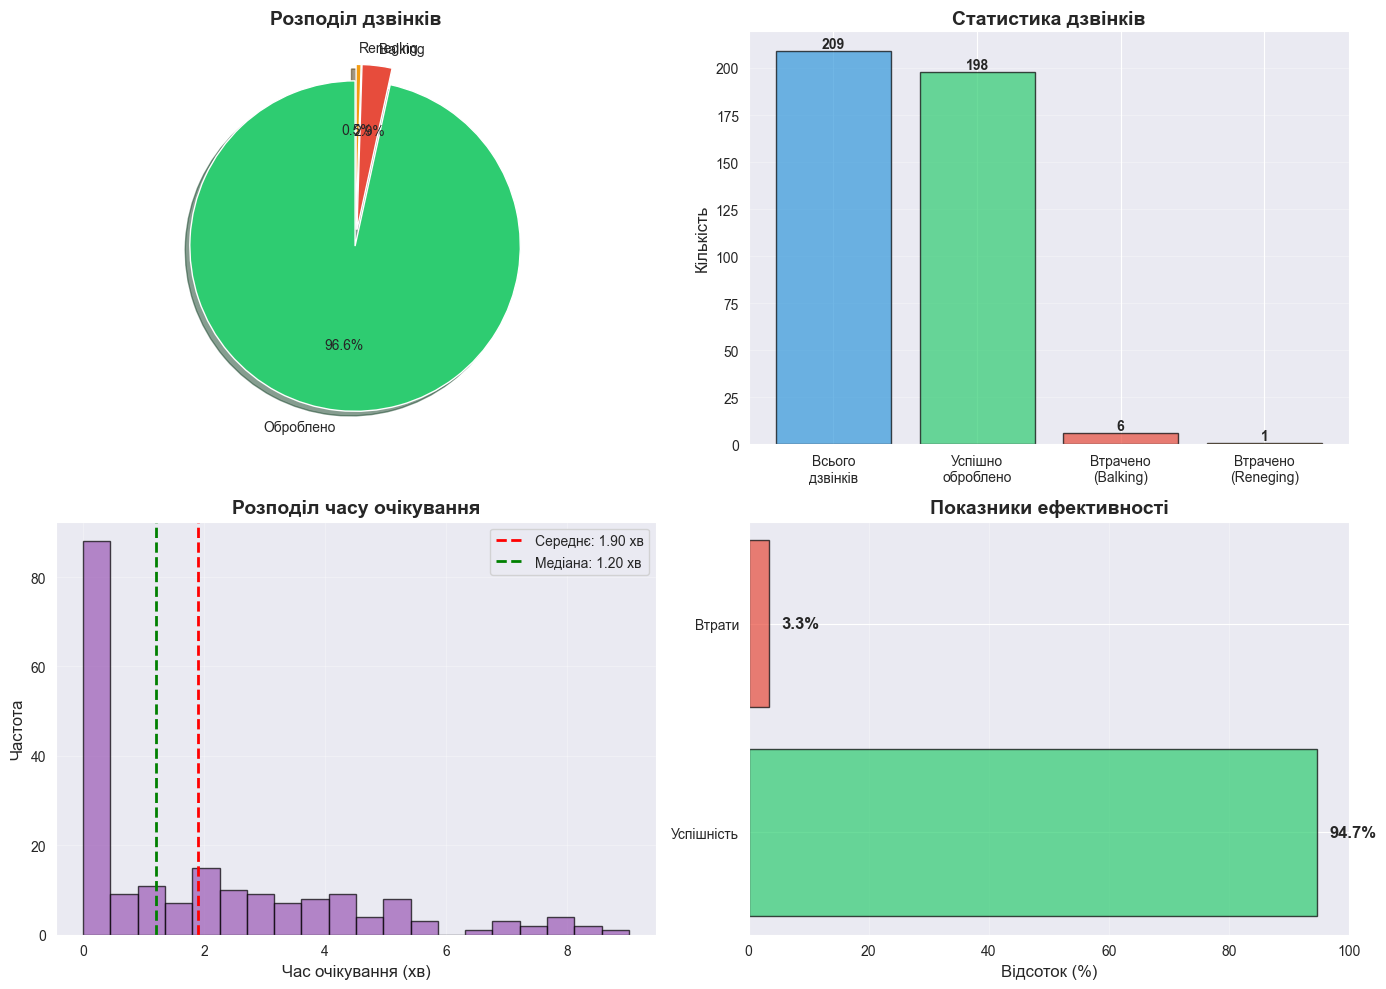

In [9]:
# Створюємо візуалізацію результатів
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Розподіл дзвінків (pie chart)
labels = ['Оброблено', 'Balking', 'Reneging']
sizes = [results.processed_calls, results.balked_calls, results.reneged_calls]
colors = ['#2ecc71', '#e74c3c', '#f39c12']
explode = (0.05, 0.05, 0.05)

axes[0, 0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
               shadow=True, startangle=90)
axes[0, 0].set_title('Розподіл дзвінків', fontsize=14, fontweight='bold')

# 2. Статистика у вигляді bar chart
categories = ['Всього\nдзвінків', 'Успішно\nоброблено', 'Втрачено\n(Balking)', 'Втрачено\n(Reneging)']
values = [results.total_calls, results.processed_calls, results.balked_calls, results.reneged_calls]
colors_bar = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = axes[0, 1].bar(categories, values, color=colors_bar, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Статистика дзвінків', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Кількість', fontsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)

# Додаємо значення над стовпцями
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold')

# 3. Гістограма часу очікування
if results.wait_times:
    axes[1, 0].hist(results.wait_times, bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(statistics.mean(results.wait_times), color='red', 
                       linestyle='--', linewidth=2, label=f'Середнє: {statistics.mean(results.wait_times):.2f} хв')
    axes[1, 0].axvline(statistics.median(results.wait_times), color='green', 
                       linestyle='--', linewidth=2, label=f'Медіана: {statistics.median(results.wait_times):.2f} хв')
    axes[1, 0].set_title('Розподіл часу очікування', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Час очікування (хв)', fontsize=12)
    axes[1, 0].set_ylabel('Частота', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Немає даних про час очікування', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Розподіл часу очікування', fontsize=14, fontweight='bold')

# 4. Відсотки втрат
lost_percent = (results.balked_calls + results.reneged_calls) / results.total_calls * 100 if results.total_calls > 0 else 0
success_percent = results.processed_calls / results.total_calls * 100 if results.total_calls > 0 else 0

metrics = ['Успішність', 'Втрати']
percentages = [success_percent, lost_percent]
colors_metrics = ['#2ecc71', '#e74c3c']

bars2 = axes[1, 1].barh(metrics, percentages, color=colors_metrics, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Показники ефективності', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Відсоток (%)', fontsize=12)
axes[1, 1].set_xlim(0, 100)
axes[1, 1].grid(axis='x', alpha=0.3)

# Додаємо відсотки
for i, (bar, pct) in enumerate(zip(bars2, percentages)):
    axes[1, 1].text(pct + 2, bar.get_y() + bar.get_height()/2., 
                    f'{pct:.1f}%',
                    ha='left', va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

## 8. Експерименти з параметрами

Давайте проведемо декілька експериментів, змінюючи параметри системи, щоб побачити як вони впливають на результати.

In [10]:
# Експеримент: Як кількість операторів впливає на якість обслуговування?

# Зберігаємо оригінальні параметри
original_operators = NUM_OPERATORS
original_verbose = VERBOSE

# Вимикаємо детальний вивід для експериментів
VERBOSE = False

# Тестуємо різну кількість операторів
operator_counts = [2, 3, 4, 5]
experiment_results = []

print("Проводимо експерименти з різною кількістю операторів...\n")

for num_ops in operator_counts:
    NUM_OPERATORS = num_ops
    print(f"Експеримент: {num_ops} операторів")
    result = run_simulation(seed=42)
    experiment_results.append(result)
    print()

# Відновлюємо оригінальні параметри
NUM_OPERATORS = original_operators
VERBOSE = original_verbose

Проводимо експерименти з різною кількістю операторів...

Експеримент: 2 операторів
СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ

ПАРАМЕТРИ:
  Час симуляції: 480 хв
  Кількість операторів: 2
  Середній інтервал між дзвінками: 2.0 хв
  Час обслуговування: 3.0-8.0 хв
  Макс. розмір черги: 5
  Терпіння клієнта: 10.0 хв
  Детальний вивід: НІ


Симуляція запущена... завершено!
РЕЗУЛЬТАТИ СИМУЛЯЦІЇ

ЗАГАЛЬНА СТАТИСТИКА:
  Загальна кількість дзвінків: 224
  Успішно оброблених: 165
  Втрачених дзвінків: 54

ВІДМОВИ:
  Balking (черга переповнена): 26 (11.6%)
  Reneging (вийшли з черги): 28 (12.5%)
  ЗАГАЛЬНИЙ % втрачених: 24.1%

ОБСЛУГОВУВАННЯ:
  Успішно оброблених: 165 (73.7%)

ЧАС ОЧІКУВАННЯ (для оброблених дзвінків):
  Середній: 5.01 хв
  Медіана: 5.14 хв
  Мінімальний: 0.00 хв
  Максимальний: 9.98 хв

Експеримент: 3 операторів
СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ

ПАРАМЕТРИ:
  Час симуляції: 480 хв
  Кількість операторів: 3
  Середній інтервал між дзвінками: 2.0 хв
  Час обслуговування: 3.0-8.0 

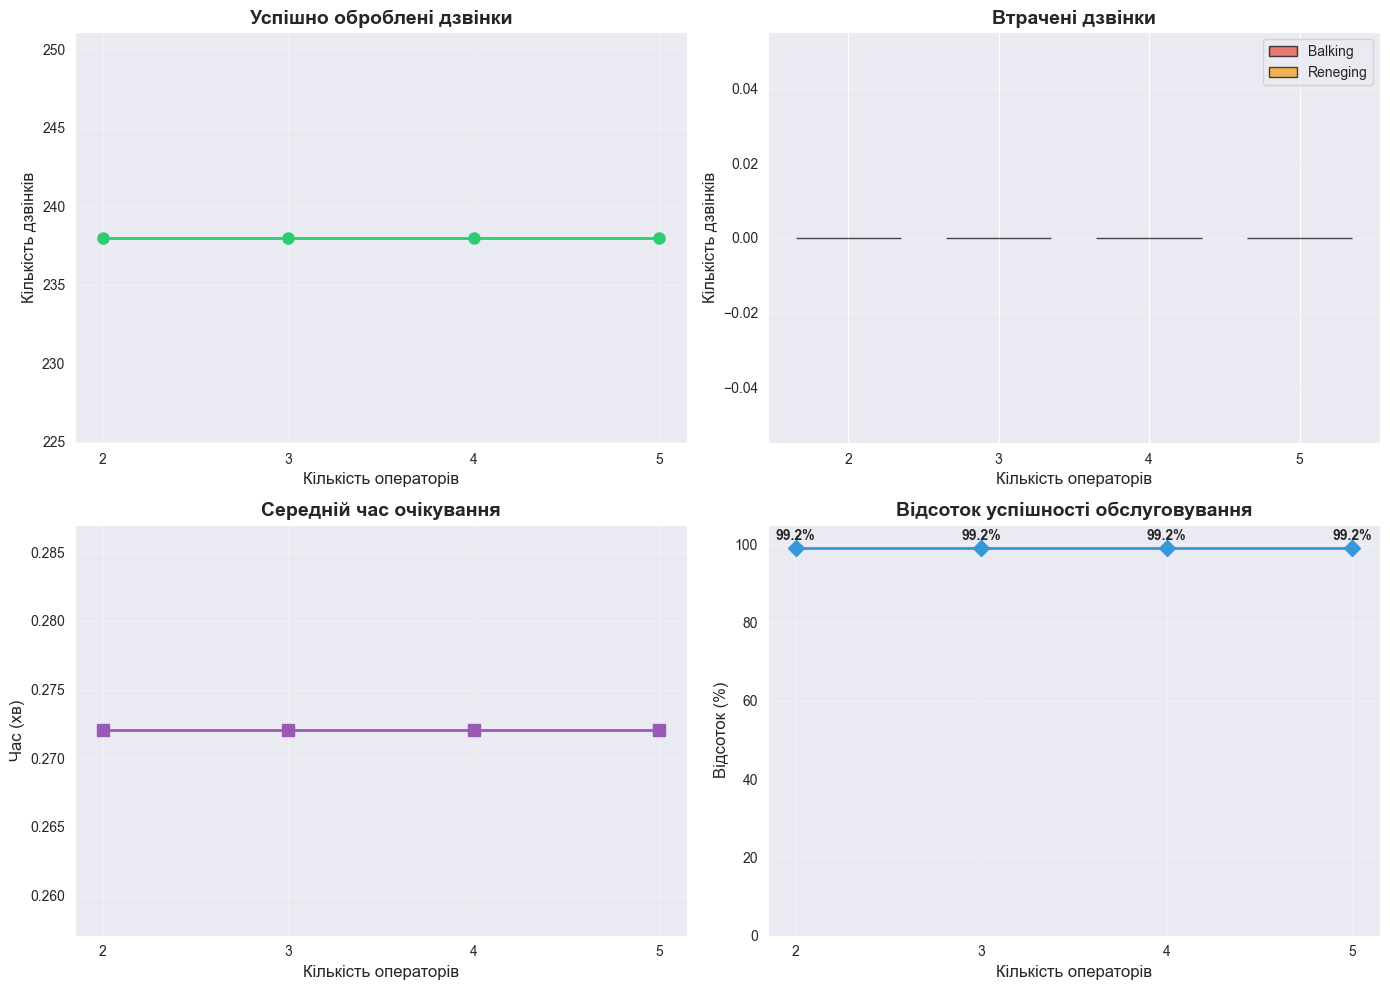


ВИСНОВКИ З ЕКСПЕРИМЕНТІВ

Вплив кількості операторів:

  2 операторів:
    - Оброблено: 238 дзвінків (99.2%)
    - Втрачено: 0 дзвінків
    - Середній час очікування: 0.27 хв

  3 операторів:
    - Оброблено: 238 дзвінків (99.2%)
    - Втрачено: 0 дзвінків
    - Середній час очікування: 0.27 хв

  4 операторів:
    - Оброблено: 238 дзвінків (99.2%)
    - Втрачено: 0 дзвінків
    - Середній час очікування: 0.27 хв

  5 операторів:
    - Оброблено: 238 дзвінків (99.2%)
    - Втрачено: 0 дзвінків
    - Середній час очікування: 0.27 хв



In [11]:
# Візуалізація результатів експериментів

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Підготовка даних
processed = [r.processed_calls for r in experiment_results]
balked = [r.balked_calls for r in experiment_results]
reneged = [r.reneged_calls for r in experiment_results]
avg_wait = [statistics.mean(r.wait_times) if r.wait_times else 0 for r in experiment_results]
success_rate = [r.processed_calls / r.total_calls * 100 if r.total_calls > 0 else 0 for r in experiment_results]

# 1. Успішно оброблені дзвінки
axes[0, 0].plot(operator_counts, processed, marker='o', linewidth=2, markersize=8, color='#2ecc71')
axes[0, 0].set_title('Успішно оброблені дзвінки', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Кількість операторів', fontsize=12)
axes[0, 0].set_ylabel('Кількість дзвінків', fontsize=12)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(operator_counts)

# 2. Втрачені дзвінки (Balking + Reneging)
width = 0.35
x_pos = np.arange(len(operator_counts))
axes[0, 1].bar(x_pos - width/2, balked, width, label='Balking', color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].bar(x_pos + width/2, reneged, width, label='Reneging', color='#f39c12', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Втрачені дзвінки', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Кількість операторів', fontsize=12)
axes[0, 1].set_ylabel('Кількість дзвінків', fontsize=12)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(operator_counts)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Середній час очікування
axes[1, 0].plot(operator_counts, avg_wait, marker='s', linewidth=2, markersize=8, color='#9b59b6')
axes[1, 0].set_title('Середній час очікування', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Кількість операторів', fontsize=12)
axes[1, 0].set_ylabel('Час (хв)', fontsize=12)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(operator_counts)

# 4. Відсоток успішності
axes[1, 1].plot(operator_counts, success_rate, marker='D', linewidth=2, markersize=8, color='#3498db')
axes[1, 1].set_title('Відсоток успішності обслуговування', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Кількість операторів', fontsize=12)
axes[1, 1].set_ylabel('Відсоток (%)', fontsize=12)
axes[1, 1].set_ylim(0, 105)
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(operator_counts)

# Додаємо значення на графік
for i, (x, y) in enumerate(zip(operator_counts, success_rate)):
    axes[1, 1].text(x, y + 2, f'{y:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Виводимо висновки
print("\n" + "=" * 70)
print("ВИСНОВКИ З ЕКСПЕРИМЕНТІВ")
print("=" * 70)
print("\nВплив кількості операторів:")
for i, num_ops in enumerate(operator_counts):
    print(f"\n  {num_ops} операторів:")
    print(f"    - Оброблено: {processed[i]} дзвінків ({success_rate[i]:.1f}%)")
    print(f"    - Втрачено: {balked[i] + reneged[i]} дзвінків")
    print(f"    - Середній час очікування: {avg_wait[i]:.2f} хв")
print("\n" + "=" * 70)

## 9. Додаткові експерименти

Ви можете провести власні експерименти, змінюючи різні параметри:

### Приклад: зміна розміру черги

```python
# Зберігаємо оригінальні параметри
original_queue_size = MAX_QUEUE_SIZE
VERBOSE = False

# Тестуємо різні розміри черги
for queue_size in [3, 5, 7, 10]:
    MAX_QUEUE_SIZE = queue_size
    print(f"Експеримент: черга розміром {queue_size}")
    run_simulation(seed=42)
    print()

# Відновлюємо оригінальні параметри
MAX_QUEUE_SIZE = original_queue_size
```

### Приклад: зміна терпіння клієнтів

```python
# Тестуємо різне терпіння
original_patience = PATIENCE_TIME
VERBOSE = False

for patience in [5, 10, 15, 20]:
    PATIENCE_TIME = patience
    print(f"Експеrimент: терпіння {patience} хв")
    run_simulation(seed=42)
    print()

PATIENCE_TIME = original_patience
```

### Детальний вивід

Щоб побачити детальний лог кожного дзвінка, встановіть `VERBOSE = True` перед запуском симуляції:

```python
VERBOSE = True
run_simulation(seed=42)
VERBOSE = False
```

---

## Ключові концепції СМО:

1. **Balking (Відмова ставати в чергу)** - клієнт бачить довгу чергу і вирішує не чекати
2. **Reneging (Вихід з черги)** - клієнт стає в чергу, але виходить через довге очікування
3. **Експоненційний розподіл** - використовується для моделювання інтервалів між дзвінками
4. **Рівномірний розподіл** - використовується для часу обслуговування

Ці два типи відмов роблять модель більш реалістичною, оскільки враховують поведінку реальних клієнтів!